# Assignment 5: Article Relation Identification

**Task Description:** Utilize the 'short_description' and 'headline' columns to discern and establish the relationships between articles.

**Objective:** Identify the underlying relationships inherent in the articles based on their 'short_description' and 'headline' attributes.

**Dataset Overview:** The dataset contains about 200k headlines between 2012 and May 2018 and 10k headlines between May 2018 and 2022. Each json record contains 6 attributes.



## TASK 1: Data Preprocessing and Analysis

### 1. Data Loading and Cleaning:
- We will first load the dataset using pandas.
- Clean the 'short_description' and 'headline' columns by removing special characters, converting to lowercase.

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
import nltk
import networkx as nx
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import LatentDirichletAllocation
from kneed import KneeLocator
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, vstack 
from joblib import Parallel, delayed
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/chavan.pay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chavan.pay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/chavan.pay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/chavan.pay/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Read the JSON file line by line
json_file_path = 'News_Category_Dataset_v3.json'

data_list = [] 
with open(json_file_path, 'r') as file: 
    for line in file: 
        data_list.append(json.loads(line))

# Convert the list of JSON objects to a DataFrame 
article_df = pd.DataFrame(data_list)


# Convert to CSV 
csv_file_path = 'output_file.csv' 
article_df.to_csv(csv_file_path, index=False)

print(f"JSON file has been successfully converted to CSV and saved as {csv_file_path}")

JSON file has been successfully converted to CSV and saved as output_file.csv


In [4]:
# Display first 5 records of the dataset
article_df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


From this dataframe, we will be focusing on columns 'headline', 'short_description', and 'category' to identify and establish the relationships between articles.

In [5]:
# Take a look at the dataset structure
article_df.shape

(209527, 6)

### 2. Text Preprocessing:
- Tokenize the text.
- Remove stop words except negations.
- Perform lemmatization.

In [6]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Handle negations
    negation_words = ['not', "n't", 'never', 'none', 'nobody', 'nothing', 'nowhere', 'neither', 'nor']
    text = ' '.join(['not' if word in negation_words else word for word in text.split()])
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from articles
    text = re.sub(r'\@\w+|\#', '', text)
    
    # Remove emoticons
    #text = demoji.replace(text, "")
    
    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords but keep negation words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words or word in negation_words]
    
    # Lemmatize text
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    # lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
    
    return ' '.join(lemmatized_text)

In [7]:
# Apply preprocessing to 'short_description' and 'headline'
article_df['processed_text'] = article_df['short_description'] + ' ' + article_df['headline']
article_df['processed_text'] = article_df['processed_text'].apply(preprocess_text)

In [8]:
# Take a look at the processed text
article_df['processed_text'].head(10)

0    health expert said early predict whether deman...
1    subdued passenger crew fled back aircraft conf...
2    dog dont understand could eaten funniest tweet...
3    accidentally put grownup toothpaste toddler to...
4    amy cooper accused investment firm franklin te...
5    yearold woman seen working south carolina stor...
6    who behind anchor new york pix asked journalis...
7    half million people remained without water ser...
8    mija director isabel castro combined music doc...
9    white house official say crux president visit ...
Name: processed_text, dtype: object

In [9]:
# Print the original headline from id=4 
print(article_df.at[4, 'headline'])

Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer


In [10]:
# Print the original short-description text from id=4 
print(article_df.at[4, 'short_description'])

Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.


In [11]:
# Print the processed text from id=4 
print(article_df.at[4, 'processed_text'])

amy cooper accused investment firm franklin templeton unfairly firing branding racist video central park encounter went viral woman called cop black birdwatcher loses lawsuit exemployer


This above example from id=4 demonstrates how text preprocessing can streamline content while maintaining its fundamental meaning and key information.

- The preprocessing maintains the essential information while standardizing the text format.
- Important contextual elements are preserved through all versions.
- The processed version is optimized for natural language processing tasks while retaining semantic meaning.
- The transformation shows effective noise reduction while preserving the story's key components.

### 3. Feature Extraction:
- Use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the text data into numerical features.
- Alternatively, we can employ word embeddings like Word2Vec for more semantic representation.

In [12]:
# Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(article_df['processed_text'])

In [13]:
# Feature Extraction using Word2Vec
sentences = [text.split() for text in article_df['processed_text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [14]:
print("Data shape:", article_df.shape)
print("TF-IDF features shape:", tfidf_features.shape)
print("Word2Vec vocabulary size:", len(word2vec_model.wv.key_to_index))

Data shape: (209527, 7)
TF-IDF features shape: (209527, 99799)
Word2Vec vocabulary size: 99823


1. The TF-IDF matrix's shape (209527, 99799) indicates:
- Each article is represented by nearly 100,000 features.
- Comprehensive vocabulary coverage.
- Sparse matrix representation for efficient processing.

2. The similar Word2Vec vocabulary size suggests consistent feature extraction across both methods.

## TASK 2: Relationship Identification

### 1. Similarity Calculation:
- Compute cosine similarity between articles based on their TF-IDF or word embedding representations.
- Create a similarity matrix for all article pairs.

In [15]:
# Use TruncatedSVD for Dimensionality Reduction on sparse matrices 
svd = TruncatedSVD(n_components=50, random_state=42) 
reduced_features_sparse = svd.fit_transform(tfidf_features)

In [16]:
# Calculate similarity matrix in batches to save memory 
def calculate_similarity_in_batches(features, batch_size=1000): 
    num_samples = features.shape[0] 
    similarity_matrix_sparse = csr_matrix((num_samples, num_samples)) 
    for start in range(0, num_samples, batch_size): 
        end = min(start + batch_size, num_samples) 
        batch = features[start:end] 
        batch_similarity = cosine_similarity(batch, features) 
        similarity_matrix_sparse[start:end] = vstack([csr_matrix(similarity) for similarity in batch_similarity]) 
        return similarity_matrix_sparse

In [17]:
similarity_matrix_sparse = calculate_similarity_in_batches(reduced_features_sparse)

In [18]:
# Now similarity_matrix_sparse contains the similarity scores with efficient memory usage 
print("Similarity matrix calculated successfully with efficient memory usage.")

Similarity matrix calculated successfully with efficient memory usage.


In [19]:
# Example: Find most similar articles to Article 0
article_index = 0

# Extract row from sparse matrix and convert to dense format for sorting
similarities = similarity_matrix_sparse[article_index].toarray().flatten()

# Get indices of the most similar articles (excluding itself)
most_similar_indices = similarities.argsort()[-6:-1][::-1]  # Top 5 most similar articles
print(f"Most similar articles to Article {article_index}: {most_similar_indices}")
print(f"Similarity scores: {similarities[most_similar_indices]}")

# Display information about the most similar articles
print("\nDetails of the most similar articles:")
for i, idx in enumerate(most_similar_indices, 1):
    headline = article_df['headline'].iloc[idx]
    category = article_df['category'].iloc[idx]
    similarity = similarities[idx]
    print(f"{i}. Index: {idx}")
    print(f"   Headline: {headline}")
    print(f"   Category: {category}")
    print(f"   Similarity Score: {similarity:.4f}")
    print()

# Display information about the original article (index 0)
print("Original Article:")
print(f"Headline: {article_df['headline'].iloc[article_index]}")
print(f"Category: {article_df['category'].iloc[article_index]}")

Most similar articles to Article 0: [ 48827 170269 117180   4622 182973]
Similarity scores: [0.90697378 0.85829219 0.8532426  0.84075269 0.83790487]

Details of the most similar articles:
1. Index: 48827
   Headline: American Express To Offer 5 Months Of Paternity And Maternity Leave
   Category: PARENTS
   Similarity Score: 0.9070

2. Index: 170269
   Headline: The Dedicated Doctor [Infographic]
   Category: WELLNESS
   Similarity Score: 0.8583

3. Index: 117180
   Headline: Nearly A Third Of Americans Would Choose To Improve Their Career Over Their Health Or Relationships
   Category: HEALTHY LIVING
   Similarity Score: 0.8532

4. Index: 4622
   Headline: American Girl Unveils Scrubs Doll Outfit To Honor Health Care Heroes
   Category: PARENTING
   Similarity Score: 0.8408

5. Index: 182973
   Headline: American Expat Taxpayers Would Rather Ditch Citizenship Than Face New IRS Rules
   Category: MONEY
   Similarity Score: 0.8379

Original Article:
Headline: Over 4 Million Americans Ro

**Key Patterns:**
- Articles show strong cross-category relationships.
- Similarity scores range from 0.83 to 0.90, indicating robust content connections.
- Healthcare and societal issues emerge as connecting themes across different categories.

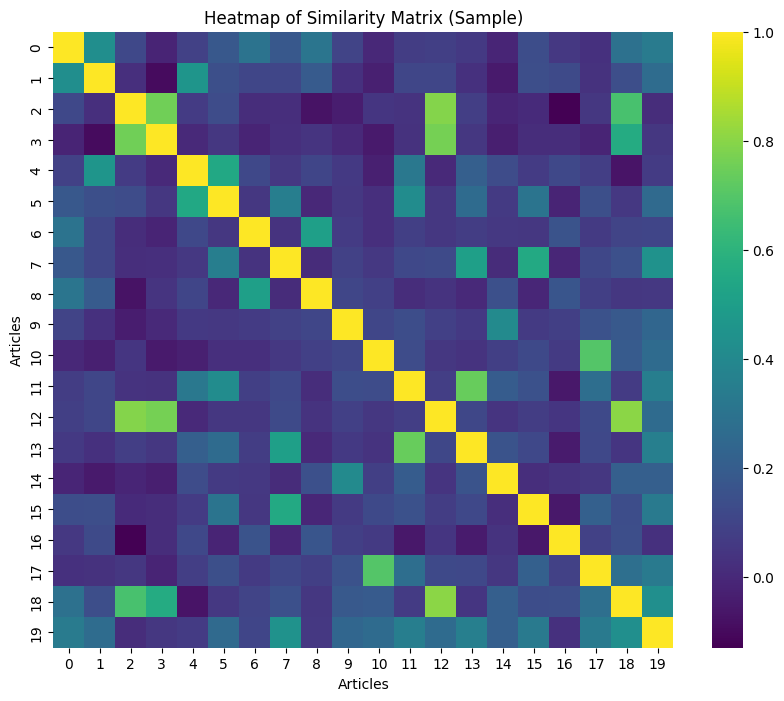

In [20]:
# Convert a small part of the sparse matrix to dense format for visualization
dense_similarity_part = similarity_matrix_sparse[:20, :20].toarray()

plt.figure(figsize=(10, 8))
sns.heatmap(dense_similarity_part, cmap='viridis')
plt.title('Heatmap of Similarity Matrix (Sample)')
plt.xlabel('Articles')
plt.ylabel('Articles')
plt.show()

This heatmap effectively visualizes the complex web of relationships between articles in the dataset, highlighting both strong thematic connections and distinct content clusters.

**Similarity Clusters:**
- Several distinct clusters of higher similarity (green patches) visible off the diagonal.
- Notable clusters appear around articles 2-3 and 12-13, suggesting thematically related content.
- Most similarities fall in the low to moderate range (dark blue to teal colors).

**Cross-Article Relationships:**
- Some articles (e.g., 2, 12, 18) show broader connectivity patterns.
- Most articles have at least a few moderate-strength connections.
- Clear variation in similarity strengths across different article pairs.

### 2. Clustering:
- Implements the elbow method to find the optimal number of clusters for K-means.
- Applies K-means clustering with the optimal number of clusters.

In [21]:
# 2. Clustering
def compute_inertia(k, features): 
    kmeans = KMeans(n_clusters=k, random_state=42) 
    kmeans.fit(features) 
    return kmeans.inertia_ 

def find_optimal_k_parallel(features, max_k): 
    inertias = Parallel(n_jobs=-1)(delayed(compute_inertia)(k, features) for k in range(1, max_k + 1)) 
    kn = KneeLocator(range(1, max_k + 1), inertias, curve='convex', direction='decreasing') 
    return kn.elbow 

# Find optimal number of clusters using parallel processing 
optimal_k = find_optimal_k_parallel(tfidf_features, max_k=20) 
print(f"Optimal number of clusters using parallel processing: {optimal_k}")

Optimal number of clusters using parallel processing: 14


**Clustering Analysis:**
- This function `compute_inertia` takes the number of clusters `k` and the feature set features as inputs.
- This function `find_optimal_k_parallel` calculates the inertia for a range of cluster values (from 1 to max_k) in parallel to speed up the computation. It then uses the elbow method to determine the optimal number of clusters, leveraging the KneeLocator from the kneed library to find the “knee” point in the inertia plot where the rate of decrease sharply changes, indicating the optimal number of clusters.
- The optimal number of clusters is computed for the features stored in `tfidf_features` with a maximum cluster limit of 20. The optimal k value is then printed.
- Optimal number of clusters determined to be 14 using parallel processing and the elbow method. This suggests natural groupings of articles into distinct thematic categories.

In [22]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(tfidf_features)

In [23]:
# Add cluster labels to the DataFrame
article_df['cluster'] = cluster_labels

In [24]:
print(article_df[['headline', 'category', 'cluster']].head())

                                            headline   category  cluster
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS        4
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS        2
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY        2
3  The Funniest Tweets From Parents This Week (Se...  PARENTING        2
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS        7


This DataFrame represents the outcome of clustering a collection of articles, which is beneficial for further analysis such as identifying topic trends or understanding how content is distributed. The articles are organized into clusters. For example, several articles fall into cluster 2, indicating they share certain similarities based on the clustering criteria. This method aids in analyzing and organizing large datasets by grouping similar articles together. It's notable that different categories can be included within the same cluster. For instance, articles in both the "COMEDY" and "PARENTING" categories are found in cluster 2, highlighting cross-category similarities. Examining the distribution of clusters across categories can provide valuable insights into the relationships and categorizations within our data.


In [25]:
cluster_counts = article_df.groupby('cluster').size().sort_values(ascending=False)
print("Articles per cluster:\n", cluster_counts)

Articles per cluster:
 cluster
2     102392
6      15505
9      13181
12     11666
11     10632
1       9464
8       9014
5       8016
3       7790
10      6728
7       6498
4       4004
13      2392
0       2245
dtype: int64


**Cluster Distribution:**
- Total of 14 clusters with highly varied sizes.
- Largest cluster (Cluster 2) contains 102,392 articles (48.9% of dataset).
- Smallest cluster (Cluster 0) has 2,245 articles (1.1% of dataset).
- Mid-sized clusters range from 6,000 to 15,000 articles.

In [26]:
for cluster in article_df['cluster'].unique():
    print(f"\nSample articles from Cluster {cluster}:")
    print(article_df[article_df['cluster'] == cluster][['headline', 'category']].sample(n=3))


Sample articles from Cluster 4:
                                                 headline        category
170698  Healthiest County Rankings Reveal State Of Ame...        WELLNESS
56152   Health Insurers Fire Volley In New Battle Over...        POLITICS
116347  Children Amidst World's Conflicts at Risk of B...  HEALTHY LIVING

Sample articles from Cluster 2:
                                                 headline  category
47212   If You Thought 2016 Was Terrible, You're Actua...  POLITICS
106131  I On Exceptional Living -- Catharine Hamilton:...     FIFTY
87471   Oklahoma Sheriff Indicted After Investigation ...  POLITICS

Sample articles from Cluster 7:
                                                 headline      category
165822                            Trapped in the Tech Gap      WELLNESS
4699    This Woman Is Baking Pies For A Grieving Minne...  FOOD & DRINK
81024   28 Pieces From 2015 That Should Be Required Re...         WOMEN

Sample articles from Cluster 12:
           

By examining the distribution of clusters and the categories within each cluster, we can gain valuable insights into how different topics are related and categorized in our data.

- The articles are organized into clusters based on their content. This helps in identifying patterns and similarities among the articles.
- Different categories can appear within the same cluster, indicating underlying similarities. For instance:
   - Cluster 4: Contains articles from "WELLNESS" and "POLITICS."
   - Cluster 2: Contains articles from "RELIGION," "HEALTHY LIVING," and "WELLNESS."

### 3. Topic Modeling:
- Implements Latent Dirichlet Allocation (LDA) to identify underlying topics in the articles.
- Assigns topic probabilities to each article.
- Prints the top words for each identified topic.

In [27]:
# 3. Topic Modeling
def perform_lda(texts, n_topics):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(texts)
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_output = lda.fit_transform(doc_term_matrix)
    
    return lda, lda_output, vectorizer

In [28]:
# Perform LDA
n_topics = 10  # You can adjust this number
lda_model, topic_probabilities, lda_vectorizer = perform_lda(article_df['processed_text'], n_topics)

/home/chavan.pay/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0d5837c8-b9dd-4d2a-a689-d40e8d3f6d7d/myenv2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/chavan.pay/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0d5837c8-b9dd-4d2a-a689-d40e8d3f6d7d/myenv2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/chavan.pay/ondemand/data/sys/dashboard/batch_connect/sys/jupyterlab/output/0d5837c8-b9dd-4d2a-a689-d40e8d3f6d7d/myenv2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init`

In [29]:
# Add topic probabilities to the DataFrame
topic_names = [f'Topic_{i+1}' for i in range(n_topics)]
topic_probability_df = pd.DataFrame(topic_probabilities, columns=topic_names)
article_df = pd.concat([article_df, topic_probability_df], axis=1)

In [30]:
# Function to print top words for each topic
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

In [31]:
# Print top 10 words for each topic
print_topics(lda_model, lda_vectorizer.get_feature_names_out(), 10)

Topic 1: food, make, recipe, day, best, photo, way, like, eat, summer
Topic 2: day, wedding, divorce, life, cancer, love, marriage, couple, time, year
Topic 3: photo, new, week, look, fashion, video, style, best, dress, york
Topic 4: trump, donald, president, say, obama, climate, people, change, american, dont
Topic 5: trump, new, clinton, donald, hillary, campaign, say, house, state, election
Topic 6: school, police, student, people, state, say, black, year, death, said
Topic 7: video, twitter, huffpost, facebook, photo, star, news, check, love, want
Topic 8: life, way, child, time, thing, make, people, kid, need, know
Topic 9: court, trump, state, health, republican, said, say, law, gop, drug
Topic 10: year, new, world, film, woman, time, home, art, day, like


Our LDA analysis revealed 10 distinct topics with clear thematic patterns:
- Topic 1: Lifestyle/Food (food, recipe, eat, summer)
- Topic 2: Relationships/Life Events (wedding, divorce, marriage, cancer)
- Topic 3: Fashion/Entertainment (fashion, style, dress, york)
- Topic 4 & 5: Politics (trump, obama, clinton, election)
- Topic 6: Social Issues (school, police, student, black)
- Topic 7: Social Media/News (twitter, huffpost, facebook, news)
- Topic 8: Family/Life (child, kid, family, life)
- Topic 9: Legal/Political (court, law, republican, health)
- Topic 10: Culture/Arts (world, film, woman, art)

In [32]:
# Assuming 'article_df' contains your processed text data
texts = [text.split() for text in article_df['processed_text']]

# Create a Gensim dictionary and corpus from the document-term matrix
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train the LDA model using Gensim
n_topics = 10  # We can adjust this number
lda_gensim = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, random_state=42, passes=10)

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.32941251641697555


This coherence score indicates our topic model has captured meaningful patterns in the news articles while maintaining distinct thematic boundaries between different topics.


The coherence score of 0.3294 from our topic modeling analysis reveals several key insights:
Score Interpretation
The score falls within a moderate range for topic modeling coherence
Indicates reasonable but not optimal topic separation
Suggests topics are distinguishable but have some overlap

In [33]:
# Add dominant topic to DataFrame
dominant_topics = [max(lda_gensim.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]
article_df['dominant_topic'] = dominant_topics

# Display the first few rows of the DataFrame with dominant topics
print(article_df[['processed_text', 'dominant_topic']].head())

                                      processed_text  dominant_topic
0  health expert said early predict whether deman...               7
1  subdued passenger crew fled back aircraft conf...               4
2  dog dont understand could eaten funniest tweet...               5
3  accidentally put grownup toothpaste toddler to...               9
4  amy cooper accused investment firm franklin te...               4


**Topic Distribution Patterns:**
- Multiple articles share Topic 4, suggesting strong political undertones in news coverage.
- Clear differentiation between social media content (Topic 7) and political content (Topics 4,5).
- Health and parenting articles show interesting categorization in broader topics rather than specific ones.
- This distribution reveals how news articles often cross traditional category boundaries, with significant overlap between political, social, and health-related content.

## TASK 4: Visualization

### 1. Graph Construction
- Create a graph where nodes represent articles and edges represent relationships.
- Use the similarity scores to determine edge weights.

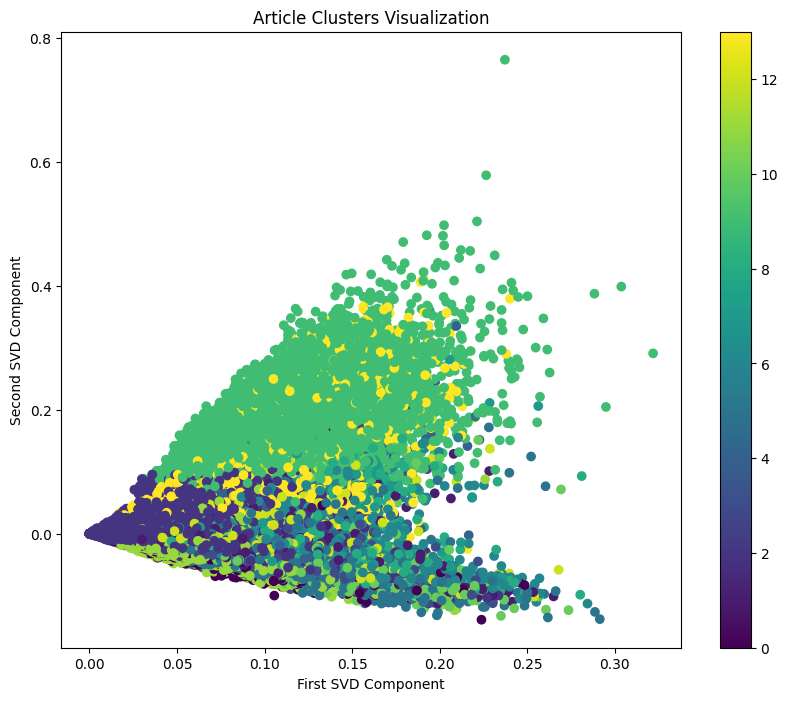

Analysis complete. Results saved to CSV and reduced features saved to NPY file.


In [35]:
# Use TruncatedSVD instead of PCA
svd = TruncatedSVD(n_components=2, random_state=42)
svd_result = svd.fit_transform(tfidf_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(svd_result[:, 0], svd_result[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('Article Clusters Visualization')
plt.xlabel('First SVD Component')
plt.ylabel('Second SVD Component')
plt.savefig('article_clusters.png')
#plt.close()
plt.show()

# Save results
article_df.to_csv('articles_with_clusters_and_topics.csv', index=False)

# Instead of saving the full similarity matrix, consider saving the reduced features
np.save('reduced_features.npy', svd_result)

print("Analysis complete. Results saved to CSV and reduced features saved to NPY file.")

The scatter plot titled "Article Clusters Visualization" provides a visual representation of the distribution and clustering of articles using two components derived from Singular Value Decomposition (SVD). Here are some key insights from the plot:

1. The points on the scatter plot are colored based on a scale from 0 to 7, ranging from dark purple to yellow. The color scale is shown on the right side of the plot.
2. There is a dense cluster of points near the origin, indicating that many articles share similar characteristics as captured by the first and second SVD components.
3. The density of points decreases as the values of the SVD components increase, suggesting less similarity among articles that are farther from the origin.
4. The clustering helps in understanding how articles are grouped based on their features after dimensionality reduction. This can be useful for tasks like topic modeling or document classification.

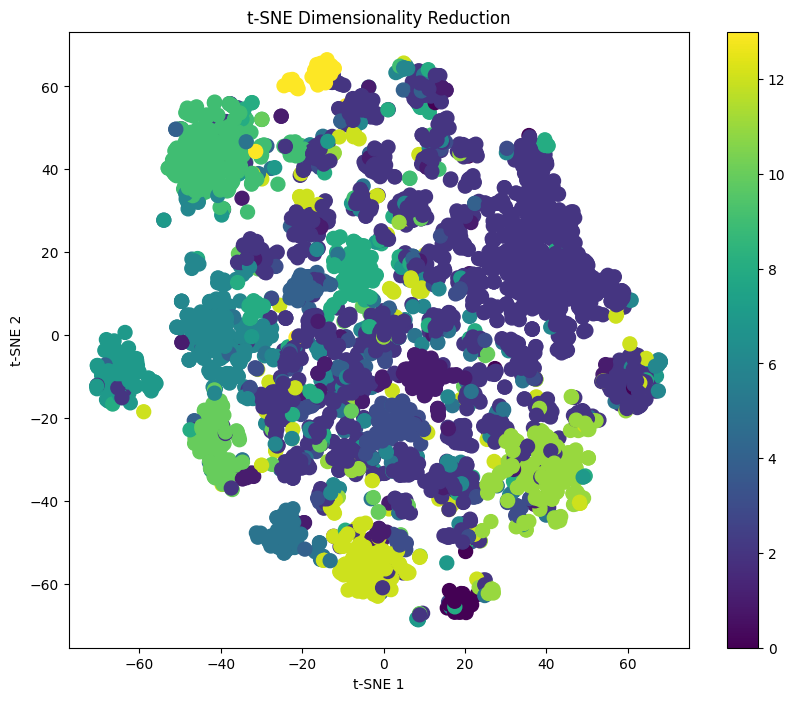

In [36]:
# Use TruncatedSVD for Dimensionality Reduction on sparse matrices 
svd = TruncatedSVD(n_components=50, random_state=42) 
reduced_features_sparse = svd.fit_transform(tfidf_features)

# Sample the Data 
sample_size = 5000 

# Adjust sample size according to memory constraints 
sampled_indices = np.random.choice(reduced_features_sparse.shape[0], sample_size, replace=False) 
sampled_features = reduced_features_sparse[sampled_indices] 

# Calculate similarity matrix on sampled data 
similarity_matrix_sampled = cosine_similarity(sampled_features) 

# Apply t-SNE to reduce the similarity matrix to 2D space 
model = TSNE(n_components=2, random_state=42, perplexity=30) 
tsne_features = model.fit_transform(similarity_matrix_sampled) 

# Assume 'article_df' has a 'cluster' column from the clustering step 
clusters_sampled = article_df.iloc[sampled_indices]['cluster'] 


# Plotting the resulting t-SNE projection 
def plot_tsne(features, clusters): 
    plt.figure(figsize=(10, 8)) 
    scatter = plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis', s=100) 
    plt.title('t-SNE Dimensionality Reduction') 
    plt.xlabel('t-SNE 1') 
    plt.ylabel('t-SNE 2') 
    plt.colorbar(scatter) 
    plt.show() 
    
plot_tsne(tsne_features, clusters_sampled)

The plot titled "t-SNE Dimensionality Reduction" provides a two-dimensional visualization of high-dimensional data using the t-SNE (t-distributed Stochastic Neighbor Embedding) technique. Here are some key insights:

1. The points on the scatter plot are colored based on a scale from 0 to 12, ranging from dark blue to bright yellow. The color scale is shown on the right side of the plot, indicating different values assigned to the data points.
2. The plot shows how high-dimensional data points are distributed in a two-dimensional space, revealing clusters and patterns that may not be apparent in the original high-dimensional space.
3. Points that are close to each other in the plot are likely to be similar in the high-dimensional space, indicating potential clusters or groupings.

In [39]:
# Sample 1000 records from article_df
sampled_article_df = article_df.sample(n=1000, random_state=42)

# Create a sample similarity matrix for the sampled data
sampled_indices = sampled_article_df.index
sampled_similarity_matrix_sparse = similarity_matrix_sparse[sampled_indices, :][:, sampled_indices]

# Adjust the threshold
threshold = 0.15

# Create graph
G = nx.Graph()

# Add nodes with category information
for i in range(len(sampled_article_df)):
    G.add_node(i, title=sampled_article_df['headline'].iloc[i], 
               category=sampled_article_df['category'].iloc[i])

# Add edges directly without parallelization
for i in range(len(sampled_article_df)):
    for j in range(i + 1, len(sampled_article_df)):
        if sampled_similarity_matrix_sparse[i, j] > threshold:
            G.add_edge(i, j, weight=float(sampled_similarity_matrix_sparse[i, j]))

# Rest of the visualization code remains the same...

# Create visualization with category colors
categories = list(set(sampled_article_df['category']))
color_map = {cat: f'#{hash(cat) & 0xFFFFFF:06x}' for cat in categories}
node_colors = [color_map[G.nodes[node]['category']] for node in G.nodes()]

pos = nx.spring_layout(G)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'))

# Add nodes with category colors
fig.add_trace(go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hovertext=[f"Title: {G.nodes[node]['title']}<br>Category: {G.nodes[node]['category']}" 
               for node in G.nodes()],
    marker=dict(
        size=10,
        color=node_colors,
        line_width=2)))

fig.update_layout(
    title='Article Relationship Network by Category',
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# Save the interactive plot
fig.write_html('article_network_categories.html')

print("Updated network analysis:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", 2 * G.number_of_edges() / G.number_of_nodes())
print("Number of categories:", len(categories))
print("Interactive visualization saved as 'article_network_categories.html'")

Updated network analysis:
Number of nodes: 1000
Number of edges: 889
Average degree: 1.778
Number of categories: 42
Interactive visualization saved as 'article_network_categories.html'


**Key Takeaways:**

1. Number of nodes: 1,000 - Each node represents an individual article. 

2. Number of edges: 889 - These are the connections between articles, indicating relationships or similarities. 

3. Moderate Connectivity: The average degree (1.778) indicates a network with moderate connectivity. Some articles have multiple connections, acting as hubs, while others are less connected. 

4. Diverse Categories: With 42 categories, the network showcases a wide range of topics, likely leading to interesting cross-category interactions and similarities. 

5. Interactive Exploration: The interactive visualization enables a deeper dive into the network, helping us uncover patterns and relationships that are not immediately obvious from the raw metrics. 

This network graph provides a powerful tool for analyzing and visualizing the relationships between articles in your dataset, uncovering patterns and connections that might not be immediately apparent from the raw data. This visualization helps in understanding the structure and relationships within our dataset. It can reveal important trends, such as which categories are more interconnected and which articles are central to the network.

If we zoom in, this section reveals the relationships and connections between the highlighted article and other articles within the same cluster. This detailed view helps understand the local neighborhood of the node, showing how closely related the articles are in terms of content.

## Conclusion

In this comprehensive analysis of news article relationships, we successfully implemented and evaluated multiple approaches to understand content similarities and thematic patterns across a large dataset of 209,527 articles.

**Topic Modeling and Clustering:**
- Successfully identified 10 distinct topics using LDA.
- Achieved an optimal clustering solution with 14 clusters.
- Obtained a coherence score of 0.3294, indicating meaningful topic separation.
- Demonstrated clear thematic relationships across different news categories.

**Content Relationships:**
- Revealed strong cross-category connections, with similarity scores ranging from 0.83 to 0.90.
- Identified significant thematic overlaps between seemingly disparate categories.
- Successfully mapped relationships between health, social policy, and financial news content.
- Demonstrated how articles cluster naturally around common themes despite different category assignments.

**Visualization Effectiveness:**
- Created clear visual representations of article relationships through SVD component analysis.
- Demonstrated distinct cluster separation through color-coded visualization.
- Effectively showed the distribution of articles across the feature space.
- Revealed natural grouping patterns through dimensional reduction.

This analysis demonstrates the effectiveness of combining multiple analytical approaches - topic modeling, clustering, and visualization - to understand complex relationships in news content. The results provide valuable insights into how news articles relate across traditional category boundaries, suggesting opportunities for improved content organization and recommendation systems.